<a href="https://colab.research.google.com/github/ajgquional/Coursera_ML-Modeling-Pipelines-in-Prod/blob/main/C3_W2_Lab_1_Manual_Dimensionality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded lab: Manual Feature Engineering
------------------------

Welcome, during this ungraded lab you are going to perform feature engineering using TensorFlow and Keras. By having a deeper understanding of the problem you are dealing with and proposing transformations to the raw features you will see how the predictive power of your model increases. In particular you will:


1. Define the model using feature columns.
2. Use Lambda layers to perform feature engineering on some of these features.
3. Compare the training history and predictions of the model before and after feature engineering.

**Note**: This lab has some tweaks compared to the code you just saw on the lectures. The major one being that time-related variables are not used in the feature engineered model.

Let's get started!

First, install and import the necessary packages, set up paths to work on and download the dataset.

## Imports

In [ ]:
# Import the packages

# Utilities
import os
import logging

# For visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# For modelling
import tensorflow as tf
from tensorflow import feature_column as fc
from tensorflow.keras import layers, models

# Set TF logger to only print errors (dismiss warnings)
logging.getLogger("tensorflow").setLevel(logging.ERROR)

## Load taxifare dataset

For this lab you are going to use a tweaked version of the [Taxi Fare dataset](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data), which has been pre-processed and split beforehand.

First, create the directory where the data is going to be saved.



In [ ]:
if not os.path.isdir("/tmp/data"):
    os.makedirs("/tmp/data")

Now download the data in `csv` format from a cloud storage bucket.

In [ ]:
!gsutil cp gs://cloud-training-demos/feat_eng/data/taxi*.csv /tmp/data

Copying gs://cloud-training-demos/feat_eng/data/taxi-test.csv...
Copying gs://cloud-training-demos/feat_eng/data/taxi-train.csv...
Copying gs://cloud-training-demos/feat_eng/data/taxi-valid.csv...
- [3 files][  5.3 MiB/  5.3 MiB]                                                
Operation completed over 3 objects/5.3 MiB.                                      


Let's check that the files were copied correctly and look like we expect them to.

In [ ]:
!ls -l /tmp/data/*.csv

-rw-r--r-- 1 root root 1113292 Jul 11 10:36 /tmp/data/taxi-test.csv
-rw-r--r-- 1 root root 3551735 Jul 11 10:36 /tmp/data/taxi-train.csv
-rw-r--r-- 1 root root  888648 Jul 11 10:36 /tmp/data/taxi-valid.csv


Everything looks fine. Notice that there are three files, one for each split of `training`, `testing` and `validation`.

## Inspect tha data

Now take a look at the training data.

In [ ]:
pd.read_csv('/tmp/data/taxi-train.csv').head()

,fare_amount,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,hourofday,dayofweek
0,8.1,1,-73.973731,40.791910,-73.962737,40.767318,14,4
1,4.5,2,-73.986495,40.739278,-73.986083,40.730933,10,6
2,2.9,1,-73.956043,40.772026,-73.956245,40.773934,22,3
3,7.0,1,-74.006557,40.705797,-73.980017,40.713617,6,3
4,6.5,1,-73.986443,40.741612,-73.990215,40.746467,10,2


The data contains a total of 8 variables.

The `fare_amount` is the target, the continuous value we’ll train a model to predict. This leaves you with 7 features.

However this lab is going to focus on transforming the geospatial ones so the time features `hourofday` and `dayofweek` will be ignored.

## Create an input pipeline

To load the data for the model you are going to use an experimental feature of Tensorflow that lets loading directly from a `csv` file.

For this you need to define some lists containing relevant information of the dataset such as the type of the columns.

In [ ]:
# Specify which column is the target
LABEL_COLUMN = 'fare_amount'

# Specify numerical columns
# Note you should create another list with STRING_COLS if you
# had text data but in this case all features are numerical
NUMERIC_COLS = ['pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude',
                'passenger_count', 'hourofday', 'dayofweek']


# A function to separate features and labels
def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label


# A utility method to create a tf.data dataset from a CSV file
def load_dataset(pattern, batch_size=1, mode='eval'):
    dataset = tf.data.experimental.make_csv_dataset(pattern, batch_size)

    dataset = dataset.map(features_and_labels)  # features, label
    if mode == 'train':
        # Notice the repeat method is used so this dataset will loop infinitely
        dataset = dataset.shuffle(1000).repeat()
        # take advantage of multi-threading; 1=AUTOTUNE
        dataset = dataset.prefetch(1)
    return dataset

## Create a DNN Model in Keras

Now you will build a simple Neural Network with the numerical features as input represented by a [`DenseFeatures`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/DenseFeatures) layer (which produces a dense Tensor based on the given features), two dense layers with ReLU activation functions and an output layer with a linear activation function (since this is a regression problem).

Since the model is defined using `feature columns` the first layer might look different to what you are used to. This is done by declaring two dictionaries, one for the inputs (defined as Input layers) and one for the features (defined as feature columns).

Then computing the `DenseFeatures` tensor by passing in the feature columns to the constructor of the `DenseFeatures` layer and passing in the inputs to the resulting tensor (this is easier to understand with code):

In [ ]:
def build_dnn_model():
    # input layer
    inputs = {
        colname: layers.Input(name=colname, shape=(), dtype='float32')
        for colname in NUMERIC_COLS
    }

    # feature_columns
    feature_columns = {
        colname: fc.numeric_column(colname)
        for colname in NUMERIC_COLS
    }

    # Constructor for DenseFeatures takes a list of numeric columns
    # and the resulting tensor takes a dictionary of Input layers
    dnn_inputs = layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of 32 and 8 units, respectively
    h1 = layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is a regression problem
    output = layers.Dense(1, activation='linear', name='fare')(h2)

    # Create model with inputs and output
    model = models.Model(inputs, output)

    # compile model (Mean Squared Error is suitable for regression)
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[
                      tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                      'mse'
                  ])

    return model

We'll build our DNN model and inspect the model architecture.

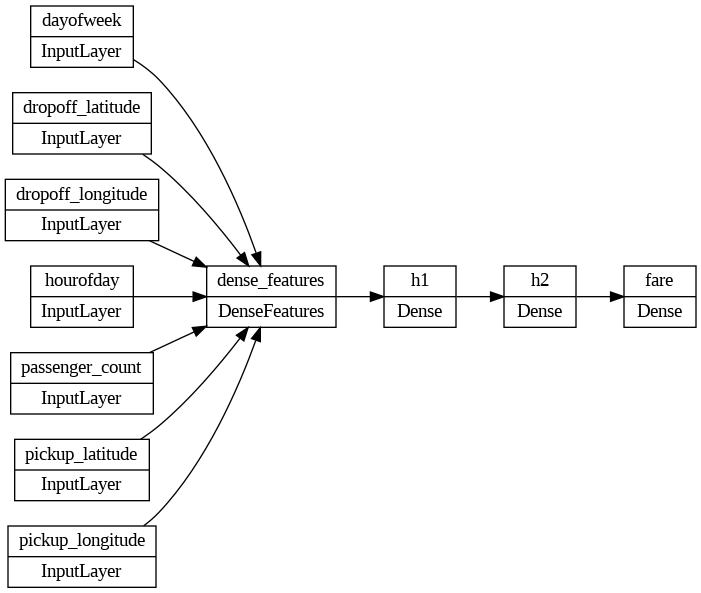

In [ ]:
# Save compiled model into a variable
model = build_dnn_model()

# Plot the layer architecture and relationship between input features
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

With the model architecture defined it is time to train it!

## Train the model

You are going to train the model for 20 epochs using a batch size of 32.

In [ ]:
NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = len(pd.read_csv('/tmp/data/taxi-train.csv'))
NUM_EVAL_EXAMPLES = len(pd.read_csv('/tmp/data/taxi-valid.csv'))

print(f"training split has {NUM_TRAIN_EXAMPLES} examples\n")
print(f"evaluation split has {NUM_EVAL_EXAMPLES} examples\n")

training split has 59620 examples

evaluation split has 14905 examples



Use the previously defined function to load the datasets from the original csv files.

In [ ]:
# Training dataset
trainds = load_dataset('/tmp/data/taxi-train*', TRAIN_BATCH_SIZE, 'train')

# Evaluation dataset
evalds = load_dataset('/tmp/data/taxi-valid*', 1000, 'eval').take(NUM_EVAL_EXAMPLES//1000)

# Needs to be specified since the dataset is infinite
# This happens because the repeat method was used when creating the dataset
steps_per_epoch = NUM_TRAIN_EXAMPLES // TRAIN_BATCH_SIZE

# Train the model and save the history
history = model.fit(trainds,
                    validation_data=evalds,
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/20
1863/1863 [==============================] - 9s 4ms/step - loss: 104.1901 - rmse: 10.2074 - mse: 104.1901 - val_loss: 101.6069 - val_rmse: 10.0800 - val_mse: 101.6069
Epoch 2/20
1863/1863 [==============================] - 5s 3ms/step - loss: 99.5716 - rmse: 9.9786 - mse: 99.5716 - val_loss: 99.3875 - val_rmse: 9.9693 - val_mse: 99.3875
Epoch 3/20
1863/1863 [==============================] - 7s 4ms/step - loss: 104.9549 - rmse: 10.2448 - mse: 104.9549 - val_loss: 99.8024 - val_rmse: 9.9901 - val_mse: 99.8024
Epoch 4/20
1863/1863 [==============================] - 5s 3ms/step - loss: 102.3329 - rmse: 10.1160 - mse: 102.3329 - val_loss: 102.5154 - val_rmse: 10.1250 - val_mse: 102.5154
Epoch 5/20
1863/1863 [==============================] - 7s 4ms/step - loss: 101.3232 - rmse: 10.0659 - mse: 101.3232 - val_loss: 98.6471 - val_rmse: 9.9321 - val_mse: 98.6471
Epoch 6/20
1863/1863 [==============================] - 6s 3ms/step - loss: 101.3076 - rmse: 10.0652 - mse: 101.3076 - val

### Visualize training curves

Now let's visualize the training history of the model with the raw features:

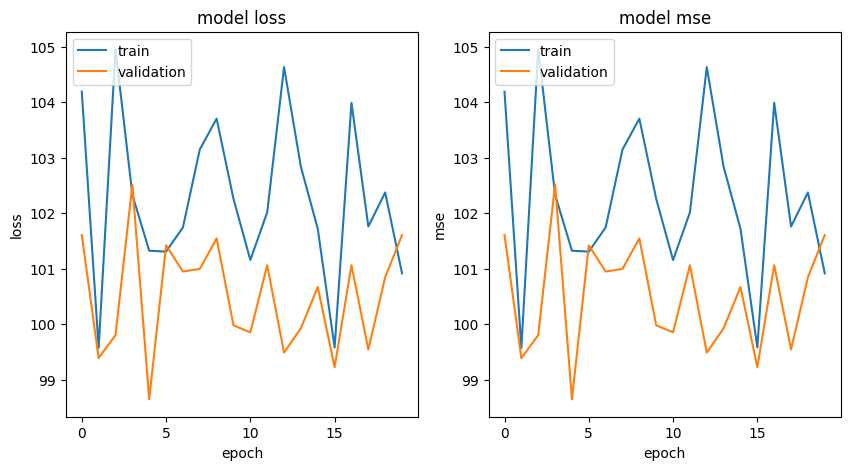

In [ ]:
# Function for plotting metrics for a given history
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history[f'val_{key}'])
        plt.title(f'model {key}')
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')


# Plot history metrics
plot_curves(history, ['loss', 'mse'])

The training history doesn't look very promising showing an erratic behaviour. Looks like the training process struggled to transverse the high dimensional space that the current features create.

Nevertheless let's use it for prediction.

Notice that the latitude and longitude values should revolve around (`37`, `45`) and (`-70`, `-78`) respectively since these are the range of coordinates for New York city.

In [ ]:
# Define a taxi ride (a data point)
taxi_ride = {
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),
    'hourofday': tf.convert_to_tensor([3.0]),
    'dayofweek': tf.convert_to_tensor([3.0]),
}

# Use the model to predict
prediction = model.predict(taxi_ride, steps=1)

# Print prediction
print(f"the model predicted a fare total of {float(prediction):.2f} USD for the ride.")

1/1 [==============================] - 0s 200ms/step
the model predicted a fare total of 11.78 USD for the ride.


<ipython-input-12-502b0264e2fb>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"the model predicted a fare total of {float(prediction):.2f} USD for the ride.")


The model predicted this particular ride to be around 12 USD. However you know the model performance is not the best as it was showcased by the training history. Let's improve it by using **Feature Engineering**.

## Improve Model Performance Using Feature Engineering

Going forward you will only use geo-spatial features as these are the most relevant when calculating the fare since this value is mostly dependent on the distance transversed:

In [ ]:
# Drop dayofweek and hourofday features
NUMERIC_COLS = ['pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude']

Since you are dealing exclusively with geospatial data you will create some transformations that are aware of this geospatial nature. This help the model make a better representation of the problem at hand.

For instance the model cannot magically understand what a coordinate is supposed to represent and since the data is taken from New York only, the latitude and longitude revolve around (`37`, `45`) and (`-70`, `-78`) respectively, which is arbitrary for the model. A good first step is to scale these values.

**Notice all transformations are created by defining functions**.

In [ ]:
def scale_longitude(lon_column):
    return (lon_column + 78)/8.

In [ ]:
def scale_latitude(lat_column):
    return (lat_column - 37)/8.

Another important fact is that the fare of a taxi ride is proportional to the distance of the ride. But as the features currently are, there is no way for the model to infer that the pair of (`pickup_latitude`, `pickup_longitude`) represent the point where the passenger started the ride and the pair (`dropoff_latitude`, `dropoff_longitude`) represent the point where the ride ended. More importantly, the model is not aware that the distance between these two points is crucial for predicting the fare.

To solve this, a new feature (which is a transformation of the other ones) that provides this information is required.

In [ ]:
def euclidean(params):
    lon1, lat1, lon2, lat2 = params
    londiff = lon2 - lon1
    latdiff = lat2 - lat1
    return tf.sqrt(londiff*londiff + latdiff*latdiff)

### Applying transformations

Now you will define the `transform` function which will apply the previously defined transformation functions. To apply the actual transformations you will be using `Lambda` layers to apply a function to values (in this case the inputs).


In [ ]:
def transform(inputs, numeric_cols):

    # Make a copy of the inputs to apply the transformations to
    transformed = inputs.copy()

    # Define feature columns
    feature_columns = {
        colname: tf.feature_column.numeric_column(colname)
        for colname in numeric_cols
    }

    # Scaling longitude from range [-70, -78] to [0, 1]
    for lon_col in ['pickup_longitude', 'dropoff_longitude']:
        transformed[lon_col] = layers.Lambda(
            scale_longitude,
            name=f"scale_{lon_col}")(inputs[lon_col])

    # Scaling latitude from range [37, 45] to [0, 1]
    for lat_col in ['pickup_latitude', 'dropoff_latitude']:
        transformed[lat_col] = layers.Lambda(
            scale_latitude,
            name=f'scale_{lat_col}')(inputs[lat_col])

    # add Euclidean distance
    transformed['euclidean'] = layers.Lambda(
        euclidean,
        name='euclidean')([inputs['pickup_longitude'],
                           inputs['pickup_latitude'],
                           inputs['dropoff_longitude'],
                           inputs['dropoff_latitude']])


    # Add euclidean distance to feature columns
    feature_columns['euclidean'] = fc.numeric_column('euclidean')

    return transformed, feature_columns

## Update the model

Next, you'll create the DNN model now with the engineered (transformed) features.

In [ ]:
def build_dnn_model():

    # input layer (notice type of float32 since features are numeric)
    inputs = {
        colname: layers.Input(name=colname, shape=(), dtype='float32')
        for colname in NUMERIC_COLS
    }

    # transformed features
    transformed, feature_columns = transform(inputs, numeric_cols=NUMERIC_COLS)

    # Constructor for DenseFeatures takes a list of numeric columns
    # and the resulting tensor takes a dictionary of Lambda layers
    dnn_inputs = layers.DenseFeatures(feature_columns.values())(transformed)

    # two hidden layers of 32 and 8 units, respectively
    h1 = layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is a regression problem
    output = layers.Dense(1, activation='linear', name='fare')(h2)

    # Create model with inputs and output
    model = models.Model(inputs, output)

    # Compile model (Mean Squared Error is suitable for regression)
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mse'])

    return model

In [ ]:
# Save compiled model into a variable
model = build_dnn_model()

Let's see how the model architecture has changed.

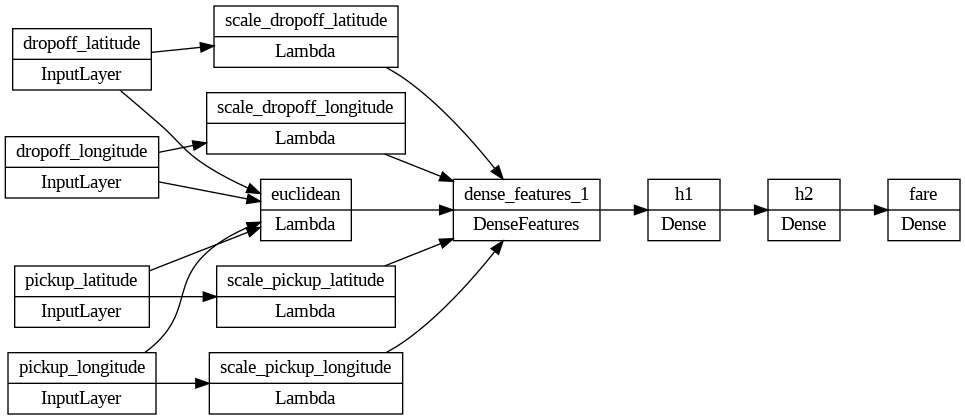

In [ ]:
# Plot the layer architecture and relationship between input features
tf.keras.utils.plot_model(model, 'dnn_model_engineered.png', show_shapes=False, rankdir='LR')

This plot is very useful for understanding the relationships and dependencies between the original and the transformed features!

**Notice that the input of the model now consists of 5 features instead of the original 7, thus reducing the dimensionality of the problem.**

Let's now train the model that includes feature engineering.

In [ ]:
# Train the model and save the history
history = model.fit(trainds,
                    validation_data=evalds,
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['passenger_count', 'hourofday', 'dayofweek'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1863/1863 [==============================] - 10s 4ms/step - loss: 90.7174 - rmse: 9.5246 - mse: 90.7174 - val_loss: 48.0386 - val_rmse: 6.9310 - val_mse: 48.0386
Epoch 2/20
1863/1863 [==============================] - 6s 3ms/step - loss: 35.7944 - rmse: 5.9828 - mse: 35.7944 - val_loss: 34.3324 - val_rmse: 5.8594 - val_mse: 34.3324
Epoch 3/20
1863/1863 [==============================] - 7s 4ms/step - loss: 33.9218 - rmse: 5.8242 - mse: 33.9218 - val_loss: 31.5537 - val_rmse: 5.6173 - val_mse: 31.5537
Epoch 4/20
1863/1863 [==============================] - 6s 3ms/step - loss: 27.2929 - rmse: 5.2243 - mse: 27.2929 - val_loss: 29.1940 - val_rmse: 5.4032 - val_mse: 29.1940
Epoch 5/20
1863/1863 [==============================] - 8s 4ms/step - loss: 29.0459 - rmse: 5.3894 - mse: 29.0459 - val_loss: 30.3219 - val_rmse: 5.5065 - val_mse: 30.3219
Epoch 6/20
1863/1863 [==============================] - 6s 3ms/step - loss: 27.8354 - rmse: 5.2759 - mse: 27.8354 - val_loss: 29.7525 - val_rmse: 5.45

Notice that the features `passenger_count`, `hourofday` and `dayofweek` were excluded since they were omitted when defining the input pipeline.

Now lets visualize the training history of the model with the engineered features.

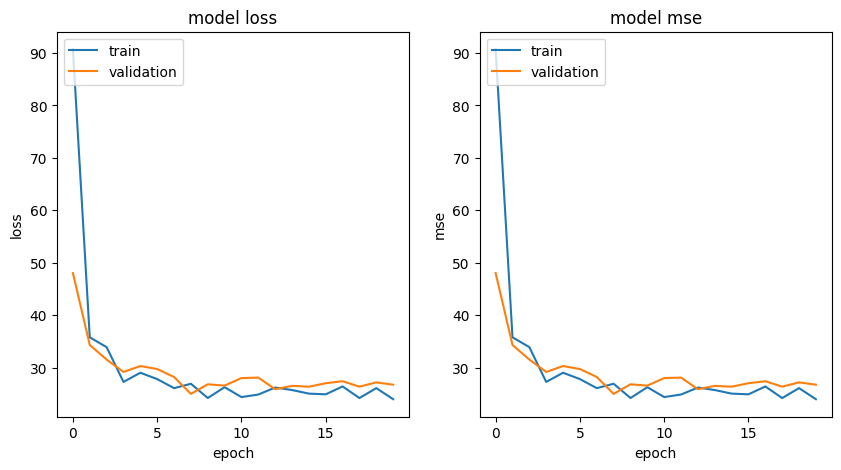

In [ ]:
# Plot history metrics
plot_curves(history, ['loss', 'mse'])

This looks a lot better than the previous training history! Now the loss and error metrics are decreasing with each epoch and both curves (train and validation) are very close to each other. Nice job!

Let's do a prediction with this new model on the example we previously used.

In [ ]:
# Use the model to predict
prediction = model.predict(taxi_ride, steps=1)

# Print prediction
print(f"the model predicted a fare total of {float(prediction):.2f} USD for the ride.")

1/1 [==============================] - 0s 151ms/step
the model predicted a fare total of 6.68 USD for the ride.


<ipython-input-23-8d72dfbe712e>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"the model predicted a fare total of {float(prediction):.2f} USD for the ride.")


Wow, now the model predicts a fare that is roughly half of what the previous model predicted! Looks like the model with the raw features was overestimating the fare by a great margin.

Notice that you get a warning since the `taxi_ride` dictionary contains information about the unused features. You can supress it by redefining `taxi_ride` without these values but it is useful to know that Keras is smart enough to handle it on its own.

**Congratulations on finishing this ungraded lab!** Now you should have a clearer understanding of the importance and impact of performing feature engineering on your data.

This process is very domain-specific and requires a great understanding of the situation that is being modelled. Because of this, new techniques that switch from a manual to an automatic feature engineering have been developed and you will check some of them in an upcoming lab.


**Keep it up!**